ТЗ: Необходмо написать нейронную сеть, для распознования рукописных и печатных матриц. Размер каждой матрицы ограничен вводом 6*6. Данные для решения задачи необходимо найти или сгенирировать самостоятельно. Для упрощения задачи, можно пока рассматривать только распознование одной матрицы.

https://proglib.io/p/neural-network-course/

https://programforyou.ru/poleznoe/convolutional-network-from-scratch-part-zero-introduction

Мне кажется, первым шагом должно быть построение классификатора, который определяет, на картинке изображена матрица или не матрица. 
Если это будет матрица, то стоит большую картинку матрицы делить на много маленьких с единственным числом на каждой, запоминая их порядок.

Будем использовать mnist, в train_y лежат размеченные данные

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow

# Импортируем основные модули pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
torch.manual_seed(178)
random.seed(178)

# Импортируем модули, связанные с компьютерным зрением
from torchvision import datasets
import torchvision.transforms as transforms

# Импортируем вспомогательные модули
from sklearn.metrics import accuracy_score

### Импорт данных

In [ ]:
rotate_transform = [transforms.RandomRotation(30)]
rotate_transform=transforms.Compose([ 
    transforms.RandomApply(rotate_transform, p=0.7),
    transforms.ToTensor()
])

In [ ]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 10
BATCH_SIZE = 128

# Загружаем данные из набора MNIST
train_data = datasets.MNIST(root='./data/train', train=True, download=True, transform=rotate_transform)
test_data = datasets.MNIST(root='./data/test', train=False, download=True, transform=rotate_transform)

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

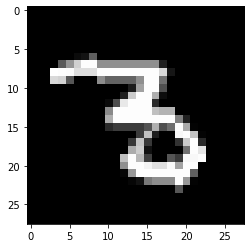

In [ ]:
plt.imshow(train_data[30][0][0], cmap=plt.get_cmap('gray'))

### Обучение

In [ ]:
class LeNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 0)
        self.conv3 = nn.Conv2d(16, 120, 5, 1, 0)
        self.pool = nn.AvgPool2d(2, 2)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        # ===============

    def forward(self, x):
        x = torch.tanh(self.conv1(x)) #28 * 28 * 6
        x = self.pool(x) #14 * 14 * 6
        x = torch.tanh(self.conv2(x)) #10 * 10 * 16
        x = self.pool(x) #5 * 5 * 16
        x = torch.tanh(self.conv3(x)) #1 * 1 * 120 = 120
        x = x.view(x.size(0), -1) #120
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x
        # ===============

In [ ]:
# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Готовимся к обучению
model = LeNet().to(device)  # создаем модель
optimizer = torch.optim.SGD(model.parameters(), lr=0.11)  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости

In [ ]:
# Начинаем обучение
for epoch in range(EPOCHS):
    for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
        # Нужно реализовать один шаг градиентного спуска
        loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
        optimizer.zero_grad()
        batch = batch.to(device)
        labels = labels.to(device)
        output = model(batch)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        # ===============
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')
    

# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
    # Оцениваем качество модели
    train_data_loader = DataLoader(train_data, batch_size=len(train_data))
    train_features, train_targets = next(iter(train_data_loader))

    train_features = train_features.to(device)
    train_model_predictions = torch.argmax(model(train_features), dim=1)
    print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions.cpu()))

    test_data_loader = DataLoader(test_data, batch_size=len(test_data))
    test_features, test_targets = next(iter(test_data_loader))

    test_features = test_features.to(device)
    test_model_predictions = torch.argmax(model(test_features), dim=1)
    print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions.cpu()))

Эпоха 1 завершилась с функцией стоимости на последнем пакете = 0.2678568363189697
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 0.2669723331928253
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 0.1455843597650528
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 0.05829780176281929
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 0.0562719888985157
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 0.11685680598020554
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 0.05930249020457268
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 0.18908435106277466
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 0.06201818212866783
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 0.07066763192415237
Точность (accuracy) на обучающей выборке: 0.9816
Точность (accuracy) на тестовой выборке: 0.9811


Необходимо проверить как алгоритм распознает реальное фото с цифрой


1.   Выделить контур
2.   Преобразование картинки к типу mnist
3.   Аугументация поворотом
4.   Kaggle



In [ ]:
## Reading an image
image = cv2.imread("/content/4.jpg", cv2.IMREAD_UNCHANGED)
print("Original shape: ", image.shape)

## New width and height to resize the image
width = 28
height = 28

ret, thresh2 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
gray = cv2.cvtColor(thresh2, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(gray, (width, height), interpolation=cv2.INTER_AREA)

#kernel = np.ones((2, 1), 'uint8')
##resized_image = cv2.erode(resized_image, kernel, iterations=1)
# kernel = np.ones((1, 2), 'uint8')
# resized_image = cv2.erode(resized_image, kernel, iterations=1)
# kernel = np.ones((1, 1), 'uint8')
# resized_image = cv2.dilate(resized_image, kernel, iterations=3)

print("Resized shape: ", resized_image.shape)
## Displaying the image
cv2_imshow(resized_image)

Original shape:  (102, 85, 3)
Resized shape:  (28, 28)


torch.Size([1, 1, 28, 28])
tensor([[ 5.5852, -9.5381, -2.0254, -0.7195,  0.3518,  1.8180,  1.3997, -2.9347,
          3.5906,  2.6569]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0], device='cuda:0')


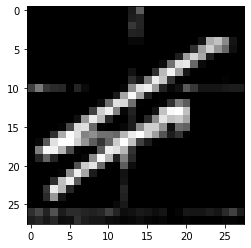

In [ ]:
torch_image = torch.tensor(resized_image.astype(np.float32))[None, None, ...].to(device)
print(torch_image.shape)
output = model(torch_image)
print(output)
test_image_prediction = torch.argmax(output, dim=1)
print(test_image_prediction)
plt.imshow(resized_image, cmap=plt.get_cmap('gray'))

tensor([[-5.1614,  2.5313,  1.9686,  9.9226, -4.1840, -0.9149, -7.2705,  2.4398,
          3.5897, -3.7447]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([3], device='cuda:0')


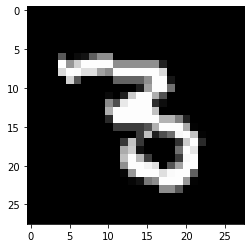

In [ ]:
output = model(train_data[30][0][None, ...].to(device)).float()
print(output)
test_image_prediction = torch.argmax(output, dim=1)
print(test_image_prediction)
plt.imshow(train_data[30][0][0], cmap=plt.get_cmap('gray'))

In [ ]:
## Reading an image
image = cv2.imread("/content/5.jpg", cv2.IMREAD_UNCHANGED)
print("Original shape: ", image.shape)

## New width and height to resize the image
width = 28
height = 28

## To gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## Resizing the image
resized_image = cv2.resize(gray, (width, height), interpolation=cv2.INTER_AREA)
print("Resized shape: ", resized_image.shape)

kernel = np.ones((2, 2), 'uint8')

resized_image = cv2.dilate(resized_image, kernel, iterations=1)

## Displaying the image
cv2_imshow(resized_image)

Original shape:  (108, 148, 3)
Resized shape:  (28, 28)


In [ ]:
ret, thresh2 = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY_INV)
gray = cv2.cvtColor(thresh2, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [ ]:
# x = cv2.Sobel(resized_image,cv2.CV_16S,1,0)
# y = cv2.Sobel(resized_image,cv2.CV_16S,0,1)
 
# absX = cv2.convertScaleAbs(x)   # Переключиться обратно на uint8
# absY = cv2.convertScaleAbs(y)
 
# resized_image = cv2.erode(resized_image, kernel, iterations=1)

# resized_image = cv2.addWeighted(absX,1,absY,0.7,0)

# cv2_imshow(resized_image)

In [ ]:
torch_image = torch.tensor(gray.astype(np.float32))[None, None, ...].to(device)
print(torch_image.shape)
output = model(torch_image)
print(output)
test_image_prediction = torch.argmax(output, dim=1)
print(test_image_prediction)
plt.imshow(gray, cmap=plt.get_cmap('gray'))

tensor([[-1.7101,  0.0480, -0.9255,  1.2122,  0.7962, -2.8537, -9.8229, 11.7312,
         -1.7583,  4.0170]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([7], device='cuda:0')


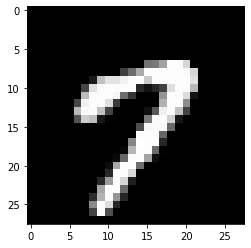

In [ ]:
output = model(train_data[15][0][None, ...].to(device)).float()
print(output)
test_image_prediction = torch.argmax(output, dim=1)
print(test_image_prediction)
plt.imshow(train_data[15][0][0], cmap=plt.get_cmap('gray'))

In [ ]:
def resize_to_28x28(img):
    img_h, img_w = img.shape
    dim_size_max = max(img.shape)

    if dim_size_max == img_w:
        im_h = (26 * img_h) // img_w
        if im_h <= 0 or img_w <= 0:
            print("Invalid Image Dimention: ", im_h, img_w, img_h)
        tmp_img = cv2.resize(img, (26,im_h),0,0,cv2.INTER_NEAREST)
    else:
        im_w = (26 * img_w) // img_h
        if im_w <= 0 or img_h <= 0:
            print("Invalid Image Dimention: ", im_w, img_w, img_h)
        tmp_img = cv2.resize(img, (im_w, 26),0,0,cv2.INTER_NEAREST)

    out_img = np.zeros((28, 28), dtype=np.ubyte)

    nb_h, nb_w = out_img.shape
    na_h, na_w = tmp_img.shape
    y_min = (nb_w) // 2 - (na_w // 2)
    y_max = y_min + na_w
    x_min = (nb_h) // 2 - (na_h // 2)
    x_max = x_min + na_h

    out_img[x_min:x_max, y_min:y_max] = tmp_img

    return out_img

def run_inference(img):
    tsr_img = resize_to_28x28(img)
    input_data = np.copy(tsr_img).reshape(1,28,28,1)

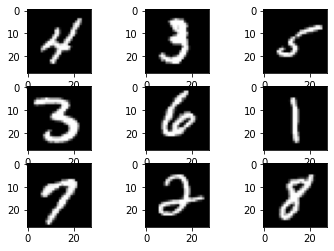

In [ ]:
for i in range(9):
  df = train_data[i+9]
  plt.subplot(331 + i)
  plt.imshow(df[0][0], cmap=plt.get_cmap('gray'))
plt.show()

Далее необходимо склеить имеющиеся картинки в матрицу, и сгенировать целый набор матриц, используя коэффициенты искожения.

Для склеивания нужно создать новый массив, который будет содержать оба вложенных массива (по горизонтали)
Для склеивания по вертикали будет создаваться новый массив с новым количеством внутренних

Создадим картинку пустоты

Напишем функцию для получения случайной картинки и функцию для генерирования матриц заданных размеров

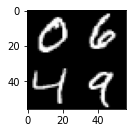

In [ ]:
def h_join(df_1, df_2):
  new_df = []
  for i in range(len(df_1)):
    new_df_df = []
    for j in range(len(df_1[0])):
      new_df_df.append(df_1[i][j])
    for j in range(len(df_2[0])):
      new_df_df.append(df_2[i][j])
    new_df.append(new_df_df)
  return new_df

def v_join(df_1, df_2):
  new_df = []
  for i in range(len(df_1)):
    new_df_df = []
    for j in range(len(df_1[0])):
      new_df_df.append(df_1[i][j])
    new_df.append(new_df_df)
  for i in range(len(df_2)):
    new_df_df = []
    for j in range(len(df_2[0])):
      new_df_df.append(df_2[i][j])
    new_df.append(new_df_df)
  return new_df

# визуализация
def visual(img):
  nrow, ncolumn = np.shape(img)
  nrow = nrow / 28
  ncolumn = ncolumn / 28
  plt.subplot(nrow, ncolumn, 1)
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.show()

img_1 = v_join(train_data[1][0][0], train_data[2][0][0])
img_2 = v_join(train_data[13][0][0], train_data[4][0][0])
img = h_join(img_1, img_2)
img = np.array(img)

visual(img)

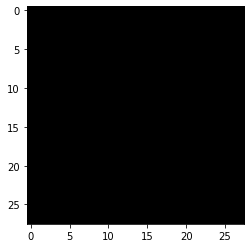

In [ ]:
img_0 = []
for i in range(28):
    img_img_0 = []
    for j in range(28):
      img_img_0.append(0)
    img_0.append(img_img_0)
img_0 = np.array(img_0)
visual(img_0)

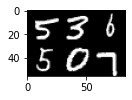

In [ ]:
def get_img():
  return train_data[round(random.random()*len(train_data))][0][0]

def create_matrix(nrow, ncol):
  first_line = True
  matrix = get_img()
  if (nrow > ncol):
    for i in range(nrow):
      img_1 = get_img()
      for j in range(ncol - 1):
        img_2 = get_img()
        img_1 = h_join(img_1, img_2)
      if (first_line):
        matrix = img_1
        first_line = False
      else:
        matrix = v_join(matrix, img_1)
  elif (nrow == ncol):
    for i in range(nrow - 1):
      img_1 = get_img()
      for j in range(ncol - 1):
        img_2 = get_img()
        img_1 = h_join(img_1, img_2)
      if (first_line):
        matrix = img_1
        first_line = False
      else:
        matrix = v_join(matrix, img_1)
  else:
    for i in range(ncol):
      img_1 = get_img()
      for j in range(nrow - 1):
        img_2 = get_img()
        img_1 = v_join(img_1, img_2)
      if (first_line):
        matrix = img_1
        first_line = False
      else:
        matrix = h_join(matrix, img_1)
  return np.array(matrix)
matrix = create_matrix(2, 3)
visual(matrix)